group testing: 7.927299999899162e-05
93
50
Epoch 0 - Training loss: 2.2422971725463867
Epoch 0 - Test loss: 2.1218338012695312
Epoch 1 - Training loss: 1.9146274328231812
Epoch 1 - Test loss: 1.6846140623092651
Epoch 2 - Training loss: 1.5477821826934814
Epoch 2 - Test loss: 1.3803260326385498
Epoch 3 - Training loss: 1.3253504037857056
Epoch 3 - Test loss: 1.204054355621338
Epoch 4 - Training loss: 1.1960409879684448
Epoch 4 - Test loss: 1.1034746170043945
Epoch 5 - Training loss: 1.1167306900024414
Epoch 5 - Test loss: 1.040459394454956
Epoch 6 - Training loss: 1.0623148679733276
Epoch 6 - Test loss: 0.9957284331321716
Epoch 7 - Training loss: 1.0211435556411743
Epoch 7 - Test loss: 0.961371660232544
Epoch 8 - Training loss: 0.9883607625961304
Epoch 8 - Test loss: 0.9332465529441833
Epoch 9 - Training loss: 0.9608021974563599
Epoch 9 - Test loss: 0.9100744128227234
Epoch 10 - Training loss: 0.9368934035301208
Epoch 10 - Test loss: 0.8893222808837891
Epoch 11 - Training loss: 1.236001

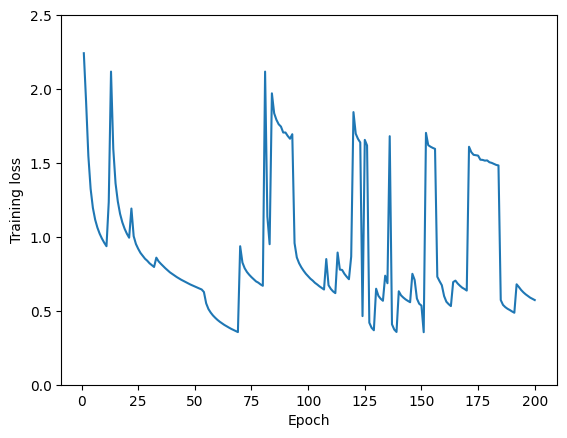

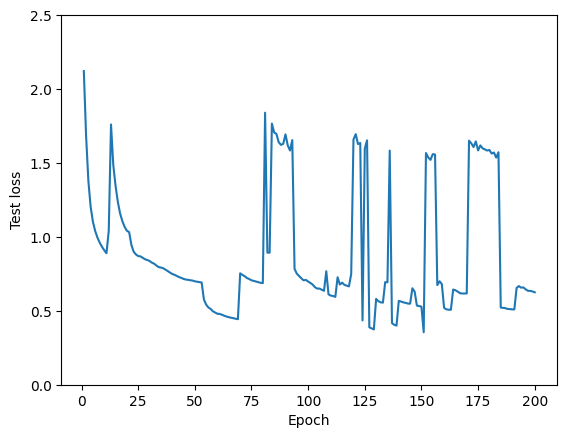

In [1]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 200
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "mean"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



group testing: 6.912499975442188e-05
78
50
Epoch 0 - Training loss: 2.2603485584259033
Epoch 0 - Test loss: 2.183387517929077
Epoch 1 - Training loss: 2.028553009033203
Epoch 1 - Test loss: 1.8216919898986816
Epoch 2 - Training loss: 1.676365613937378
Epoch 2 - Test loss: 1.5269980430603027
Epoch 3 - Training loss: 1.4304529428482056
Epoch 3 - Test loss: 1.3634036779403687
Epoch 4 - Training loss: 1.2769973278045654
Epoch 4 - Test loss: 1.264845371246338
Epoch 5 - Training loss: 1.178719401359558
Epoch 5 - Test loss: 1.2028403282165527
Epoch 6 - Training loss: 1.1120214462280273
Epoch 6 - Test loss: 1.1580833196640015
Epoch 7 - Training loss: 1.0626606941223145
Epoch 7 - Test loss: 1.122694969177246
Epoch 8 - Training loss: 1.0244667530059814
Epoch 8 - Test loss: 1.0930808782577515
Epoch 9 - Training loss: 0.9938793778419495
Epoch 9 - Test loss: 1.0705647468566895
Epoch 10 - Training loss: 0.9683111906051636
Epoch 10 - Test loss: 1.0529412031173706
Epoch 11 - Training loss: 1.199395775

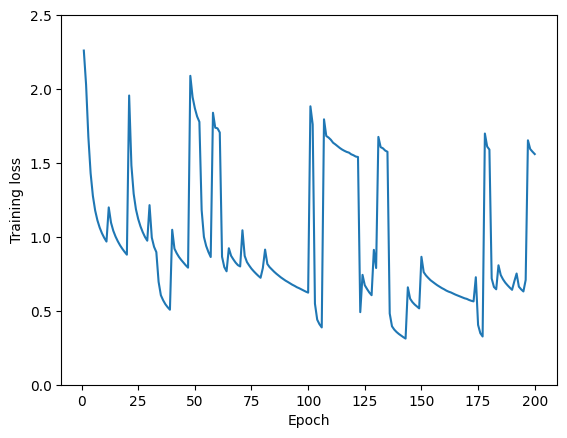

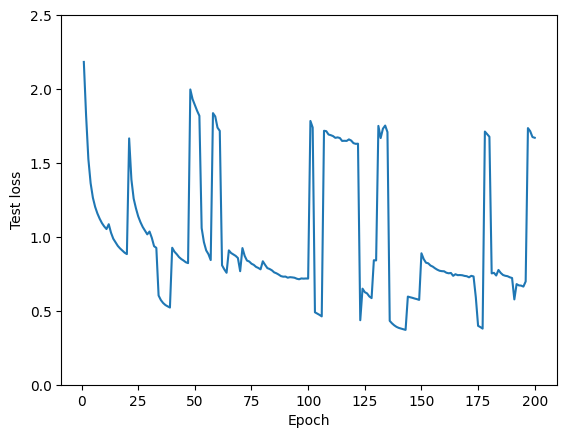

In [3]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 200
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "wei"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

